In [51]:
#!pip install gym==0.17.2
#!pip install gym-super-mario-bros==7.3.0
#!pip install nes-py==8.1.8
#!pip install tf-agents==0.5.0
#!pip install tensorflow==2.2.0

#librerias necesarias
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install swig
!pip install gym[atari,box2d,accept-rom-license]  #install gym and virtual display
!pip install gym-super-mario-bros


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease              
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Hit:5 https://packages.cloud.google.com/apt gcsfuse-focal InRelease            
Hit:6 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:8 https://packages.cloud.google.com/apt google-fast-socket InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1159 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2319 kB]
Fetched 3734 kB in 1s (3279 kB/s)  
Reading package lists... Done
W: https://packages.cloud.google.com/apt/dists/gcsfuse-focal/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trust

In [52]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.environments.wrappers import ActionRepeat
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.utils import common
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver


from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment

import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# To get smooth animations
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml')

# Importar las librerías necesarias

from tf_agents.environments import gym_wrapper, tf_py_environment
import matplotlib.animation as animation 
from IPython.display import HTML


/opt/conda/lib/python3.10/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']


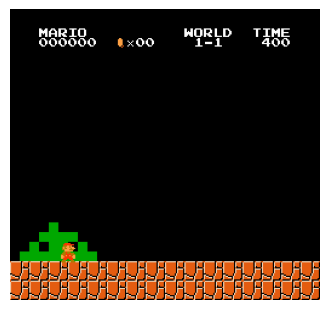

In [53]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
print(env.get_action_meanings())
state = env.reset()
env.step(env._action_space.sample())
img = env.render(mode="rgb_array")
plt.figure(figsize=(4, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [54]:
# Create and wrap the environment
def create_environment():
    # Load the Super Mario Bros environment
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    # Simplify the action space
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    # Apply preprocessing wrappers
    env = gym.wrappers.GrayScaleObservation(env, keep_dim=True)
    env = gym.wrappers.ResizeObservation(env, 84)
    env = gym.wrappers.FrameStack(env, 4)
    env = gym_wrapper.GymWrapper(env)
    return env

In [55]:
# Instantiate training and evaluation environments
train_py_env = create_environment()
eval_py_env = create_environment()

In [56]:
# Convert to TensorFlow Agents environments
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [57]:
# Define the Q-network with adjusted parameters
preprocessing_layer = tf.keras.layers.Lambda(lambda x: tf.cast(x, np.float32) / 255.)
conv_layer_params = [
    (16, (8, 8), 4),
    (32, (4, 4), 2),
    (32, (3, 3), 1),
]
fc_layer_params = [256]

q_net = QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

# Create the DQN agent with updated optimizer and epsilon_greedy
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=2.5e-4,
    rho=0.95,
    momentum=0.0,
    epsilon=0.01,
    centered=True
)
train_step_counter = tf.Variable(0)

agent = DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    gamma=0.99,
    epsilon_greedy=1.0,  # Comienza con alta exploración
    target_update_period=10000
)

agent.initialize()


In [58]:
# Create the replay buffer
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=40000
)

In [59]:
# Function to collect experience
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# Collect initial data with a random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
initial_collect_steps = 1000

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy, replay_buffer)

# Prepare the dataset
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=2
).prefetch(3)
iterator = iter(dataset)

In [60]:
# Training the agent
num_iterations = 5000  # Adjust this value based on Kaggle's computational limits
collect_steps_per_iteration = 4
log_interval = 500

for iteration in range(num_iterations):
    # Collect experience
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data and train the agent
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    if iteration % log_interval == 0:
        print(f'Iteration: {iteration}, Loss: {train_loss}')



I0000 00:00:1728416331.650461      30 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 0, Loss: 1.3625686168670654
Iteration: 500, Loss: 0.22934818267822266
Iteration: 1000, Loss: 0.18958213925361633
Iteration: 1500, Loss: 0.14956620335578918
Iteration: 2000, Loss: 0.15161676704883575
Iteration: 2500, Loss: 0.07563052326440811
Iteration: 3000, Loss: 0.1683838665485382
Iteration: 3500, Loss: 0.15488480031490326
Iteration: 4000, Loss: 0.13479465246200562
Iteration: 4500, Loss: 0.21518202126026154


In [61]:
# Evaluar el rendimiento del agente
for episode in range(num_eval_episodes):
    time_step = eval_env.reset()
    episode_reward = 0
    step = 0
    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        print(f"Paso {step}, Acción tomada: {action_step.action}")
        time_step = eval_env.step(action_step.action)
        episode_reward += time_step.reward
        step += 1
    print(f'Episodio {episode + 1}: Recompensa = {episode_reward.numpy()[0]}')


Paso 0, Acción tomada: [0]
Paso 1, Acción tomada: [0]
Paso 2, Acción tomada: [0]
Paso 3, Acción tomada: [0]
Paso 4, Acción tomada: [0]
Paso 5, Acción tomada: [0]
Paso 6, Acción tomada: [0]
Paso 7, Acción tomada: [0]
Paso 8, Acción tomada: [0]
Paso 9, Acción tomada: [0]
Paso 10, Acción tomada: [0]
Paso 11, Acción tomada: [0]
Paso 12, Acción tomada: [0]
Paso 13, Acción tomada: [0]
Paso 14, Acción tomada: [0]
Paso 15, Acción tomada: [0]
Paso 16, Acción tomada: [0]
Paso 17, Acción tomada: [0]
Paso 18, Acción tomada: [0]
Paso 19, Acción tomada: [0]
Paso 20, Acción tomada: [0]
Paso 21, Acción tomada: [0]
Paso 22, Acción tomada: [0]
Paso 23, Acción tomada: [0]
Paso 24, Acción tomada: [0]
Paso 25, Acción tomada: [0]
Paso 26, Acción tomada: [0]
Paso 27, Acción tomada: [0]
Paso 28, Acción tomada: [0]
Paso 29, Acción tomada: [0]
Paso 30, Acción tomada: [0]
Paso 31, Acción tomada: [0]
Paso 32, Acción tomada: [0]
Paso 33, Acción tomada: [0]
Paso 34, Acción tomada: [0]
Paso 35, Acción tomada: [0]
Pa

In [62]:
# Evaluate the agent's performance
log_interval = 5
num_eval_episodes = 5
for episode in range(num_eval_episodes):
    time_step = eval_env.reset()
    episode_reward = 0
    i = 0
    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        episode_reward += time_step.reward
        i+=1
       
        if i % log_interval == 0:
            print(f'Episode {episode + 1}: Ite.: {i} :episode_reward : {episode_reward.numpy()[0]}')
    #print(f'Episode {episode + 1}: Reward = {episode_reward.numpy()[0]}')

Episode 1: Ite.: 5 :episode_reward : 0.0
Episode 1: Ite.: 10 :episode_reward : 0.0
Episode 1: Ite.: 15 :episode_reward : 0.0
Episode 1: Ite.: 20 :episode_reward : -1.0
Episode 1: Ite.: 25 :episode_reward : -1.0
Episode 1: Ite.: 30 :episode_reward : -1.0
Episode 1: Ite.: 35 :episode_reward : -1.0
Episode 1: Ite.: 40 :episode_reward : -2.0
Episode 1: Ite.: 45 :episode_reward : -2.0
Episode 1: Ite.: 50 :episode_reward : -2.0
Episode 1: Ite.: 55 :episode_reward : -2.0
Episode 1: Ite.: 60 :episode_reward : -3.0
Episode 1: Ite.: 65 :episode_reward : -3.0
Episode 1: Ite.: 70 :episode_reward : -3.0
Episode 1: Ite.: 75 :episode_reward : -3.0
Episode 1: Ite.: 80 :episode_reward : -4.0
Episode 1: Ite.: 85 :episode_reward : -4.0
Episode 1: Ite.: 90 :episode_reward : -4.0
Episode 1: Ite.: 95 :episode_reward : -4.0
Episode 1: Ite.: 100 :episode_reward : -5.0
Episode 1: Ite.: 105 :episode_reward : -5.0
Episode 1: Ite.: 110 :episode_reward : -5.0
Episode 1: Ite.: 115 :episode_reward : -5.0
Episode 1: 

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


# Visualization functions provided
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Collect frames for visualization
def run_and_visualize(agent, env):
    frames = []
    time_step = env.reset()
    policy_state = agent.policy.get_initial_state(env.batch_size)
    while not time_step.is_last():
        action_step = agent.policy.action(time_step, policy_state)
        policy_state = action_step.state
        time_step = env.step(action_step.action)
        frame = env.pyenv.envs[0].render(mode='rgb_array')
        frames.append(frame)
    return frames

# Run the agent and collect frames
frames = run_and_visualize(agent, eval_env)

# Create and display the animation
anim = plot_animation(frames)


HTML(anim.to_jshtml())



In [ ]:
# Evaluar el rendimiento del agente
for episode in range(num_eval_episodes):
    time_step = eval_env.reset()
    episode_reward = 0
    step = 0
    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        print(f"Paso {step}, Acción tomada: {action_step.action}")
        time_step = eval_env.step(action_step.action)
        episode_reward += time_step.reward
        step += 1
    print(f'Episodio {episode + 1}: Recompensa = {episode_reward.numpy()[0]}')
